In [1]:
%pylab inline
import sys
sys.path.append("..")
from loaders import imagenet_load
from importlib import reload
print(imagenet_load)
from conv import multigpu
from loaders.imagenet_load import orient
import conv
from conv import filter_gen, multigpu
from opt import ls
import numpy as np
from utils import misc
from utils import linalg
from utils import exputil
from numba import jit
import math
import concurrent.futures as fs
from pylab import imshow
import copy
from skimage.filters import gabor_kernel
from skimage.transform import rescale
from sklearn import metrics

Populating the interactive namespace from numpy and matplotlib
<module 'loaders.imagenet_load' from '../loaders/imagenet_load.py'>


In [2]:
NUM_CLASSES = 10

In [3]:

def class_to_tarball_name_train(classname):
    classname = classname.strip()
    return "/home/ubuntu/imagenet-train/{0}-scaled.tar".format(classname)

def class_to_tarball_name_val(classname):
    classname = classname.strip()
    return "/home/ubuntu/imagenet-validation/val-{0}-scaled.tar".format(classname)



In [978]:
def normalize_images(images, mean_rgb=mean_rgb, min_divisor=1e-8, mode="CHW"):
    if (mode == "HWC"):
        images = images.transpose(0,3,1,2)
    images /= 255.0

    orig_shape = images.shape
    images = images.reshape(images.shape[0], -1)
    n_images = images.shape[0]
    # Zero mean every feature
    images = images - np.mean(images, axis=1)[:,np.newaxis]
    # Normalize
    image_norms = np.linalg.norm(images, axis=1)/55.0
    # Get rid of really small norms
    image_norms[np.where(image_norms < min_divisor)] = 1
    # Make features unit norm
    images_normalized = images/image_norms[:,np.newaxis]
    images_normalized = images_normalized.reshape(orig_shape)
    if (mode == "HWC"):
        images_normalized = images_normalized.transpose(0,2,3,1)
    return images_normalized

In [979]:
%time loader_train = imagenet_load.ImagenetLoader(NUM_CLASSES, classes_path="../loaders/classes", tarball_func=class_to_tarball_name_train, mmap_loc="/dev/shm/imagenet_train", n_procs=16)
%time loader_val = imagenet_load.ImagenetLoader(NUM_CLASSES, classes_path="../loaders/classes", tarball_func=class_to_tarball_name_val, mmap_loc="/dev/shm/imagenet_val", n_procs=16)

%time X_train = loader_train.load_all()
%time X_test = loader_val.load_all()

There exists a matrix at /dev/shm/imagenet_train


CPU times: user 24 ms, sys: 1.19 s, total: 1.22 s
Wall time: 1.46 s


There exists a matrix at /dev/shm/imagenet_val


CPU times: user 28 ms, sys: 860 ms, total: 888 ms
Wall time: 1.04 s
Loaded 0 classes into mem
CPU times: user 36 ms, sys: 868 ms, total: 904 ms
Wall time: 3.75 s
Loaded 0 classes into mem
CPU times: user 20 ms, sys: 884 ms, total: 904 ms
Wall time: 1.14 s


In [980]:
y_train = loader_train.Y
y_test = loader_val.Y

In [981]:
mean_rgb = np.mean(X_train, axis=(0,2,3))

In [982]:
def normalize_patches(patches, min_divisor=1e-8, zca_bias=0.1, mean_rgb=np.array([0,0,0])):
    patches /= 255.0
    n_patches = patches.shape[0]
    orig_shape = patches.shape
    
    patches = patches.reshape(patches.shape[0], -1)
    # Zero mean every feature
    patches = patches - np.mean(patches, axis=1)[:,np.newaxis]

    # Normalize
    patch_norms = np.linalg.norm(patches, axis=1)

    # Get rid of really small norms
    patch_norms[np.where(patch_norms < min_divisor)] = 1

    # Make features unit norm
    patches = patches/patch_norms[:,np.newaxis]

    data_means = np.mean(patches, axis=1)

    patchesCovMat = 1.0/n_patches * patches.T.dot(patches)

    (E,V) = np.linalg.eig(patchesCovMat)

    E += zca_bias
    sqrt_zca_eigs = np.sqrt(E)
    
    inv_sqrt_zca_eigs = np.diag(np.power(sqrt_zca_eigs, -1))
    
    global_ZCA = V.dot(inv_sqrt_zca_eigs).dot(V.T)
    
    patches_normalized = (patches).dot(global_ZCA).dot(global_ZCA.T)

    return patches_normalized.reshape(orig_shape)


@jit(nopython=True, nogil=True, cache=True)
def __grab_patches(images, patch_size=6, tot_patches=1e6, seed=0):
    np.random.seed(seed)
    tot_patches = int(tot_patches)
    im_idxs = np.random.choice(images.shape[0], tot_patches)
    idxs_x = np.random.choice(images.shape[3] - patch_size - 1, tot_patches)
    idxs_y = np.random.choice(images.shape[2] - patch_size - 1, tot_patches)
    idxs_x += int(math.ceil(patch_size/2))
    idxs_y += int(math.ceil(patch_size/2))
    patches = np.zeros((tot_patches, images.shape[1], patch_size, patch_size), dtype=np.float32)
    for i, (im_idx, idx_x, idx_y) in enumerate(zip(im_idxs, idxs_x, idxs_y)):
        out_patch = patches[i, :, :, :]
        grab_patch_from_idx(images[im_idx], idx_x, idx_y, patch_size, out_patch)
    return patches
    
@jit(nopython=True, nogil=True)
def grab_patch_from_idx(im, idx_x, idx_y, patch_size, outpatch):
    sidx_x = int(idx_x - patch_size/2)
    eidx_x = int(idx_x + patch_size/2)
    sidx_y = int(idx_y - patch_size/2)
    eidx_y = int(idx_y + patch_size/2)
    outpatch[:,:,:] = im[:, sidx_x:eidx_x, sidx_y:eidx_y,].astype(np.float32)
    return outpatch

def grab_patches(images, patch_size=6, tot_patches=5e5, seed=0, max_threads=50):
    idxs = misc.chunk_idxs(images.shape[0], max_threads)
    tot_patches = int(tot_patches)
    patches_per_thread = int(tot_patches/max_threads)
    with fs.ThreadPoolExecutor(max_workers=max_threads) as executor:
        futures = []
        for i,(sidx, eidx) in enumerate(idxs):
            futures.append(executor.submit(__grab_patches, images[sidx:eidx, :], 
                                           patch_size=patch_size,
                                           tot_patches=patches_per_thread,
                                           seed=seed+i
                                          ))
            
        results = np.vstack(list(map(lambda x: x.result(), futures)))
    return results 


In [983]:
subsample = np.random.choice(X_train.shape[0], 13000, replace=False)
X_subsampled = X_train[subsample].astype('float32')

In [984]:
%time normalized_subsample = normalize_images(X_subsampled, mean_rgb=mean_rgb)

CPU times: user 8.96 s, sys: 6.73 s, total: 15.7 s
Wall time: 15.7 s


In [985]:
patch_size = 12
%time patches = grab_patches(X_subsampled, patch_size=patch_size)

CPU times: user 1.4 s, sys: 1min 49s, total: 1min 51s
Wall time: 3.04 s


In [986]:
patches_normalized = normalize_patches(patches, mean_rgb=mean_rgb)

In [1113]:
reload(filter_gen)
patches_mmap_data = np.memmap("/dev/shm/imagenet_patches", shape=patches.shape, dtype=patches.dtype, mode="w+")
np.copyto(patches_mmap_data, patches)
patches_mmap = multigpu.MmapArray(patches_mmap_data, mode="r+")

patches_normalized_mmap_data = np.memmap("/dev/shm/imagenet_patches_normalized", shape=patches.shape, dtype=patches.dtype, mode="w+")
np.copyto(patches_normalized_mmap_data, patches_normalized)
patches_normalized_mmap = multigpu.MmapArray(patches_normalized_mmap_data, mode="r+")

fg_patches = filter_gen.make_empirical_filter_gen(patches_mmap, seed=0)
fg_patches_normalized = filter_gen.make_empirical_filter_gen(patches_normalized_mmap, seed=0)

In [1115]:
gpu_handler = multigpu.MultiGpuHandler(16)
gpu_handler.kill_all_gpu_processes()
gpu_handler.start_and_wait_for_gpu_init()

In [1116]:

conv_args_template = \
{ 
  "num_feature_batches":16,
  "data_batch_size":8,
  "feature_batch_size":1024,
  "pool_size":70,
  "pool_type":"avg",
  "pool_stride":45,
  "patch_size":patch_size,
  "pad":0,
  "bias": 1.0,
  "conv_stride":2,
  "preprocess_batch": normalize_images
}

X_train_mmap = multigpu.MmapArray(X_train, mode="r+")
X_test_mmap = multigpu.MmapArray(X_test, mode="r+")

mmap_out_train_shape = conv.conv_compute_output_shape(data=X_train_mmap, **conv_args_template)
X_train_lift = np.memmap("/dev/shm/X_train_lift", mode="w+", dtype="float32", shape=mmap_out_train_shape)

mmap_out_test_shape = conv.conv_compute_output_shape(data=X_test_mmap, **conv_args_template)
X_test_lift = np.memmap("/dev/shm/X_test_lift", mode="w+", dtype="float32", shape=mmap_out_test_shape)

In [1117]:
mmap_out_train_shape

(13000, 32768, 3, 3)

In [1118]:
fg_patches = filter_gen.make_empirical_filter_gen(patches_normalized_mmap, MIN_VAR_TOL=0, seed=0)

In [1119]:
im = fg_patches(1024)

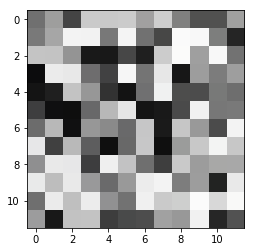

In [1120]:
imshow(orient(im[4]))

In [1121]:
X_train_lift_mmap = multigpu.MmapArray(X_train_lift, mode="r+")
X_test_lift_mmap = multigpu.MmapArray(X_test_lift, mode="r+")


In [1122]:
train_chunk_idxs = misc.chunk_idxs(X_train.shape[0], 16)
test_chunk_idxs = misc.chunk_idxs(X_test.shape[0], 16)

In [1123]:
gpu_results = []
for gpu, (sidx, eidx) in list(zip(gpu_handler.gpus, train_chunk_idxs)):
        fg_patches = filter_gen.make_empirical_filter_gen(patches_normalized_mmap, MIN_VAR_TOL=0, seed=0)
        conv_args = conv_args_template.copy()
        conv_args["filter_gen"] = fg_patches
        X_train_mmap_gpu = copy.copy(X_train_mmap)
        X_train_mmap_gpu.idxs = (sidx, eidx)
        X_train_out_gpu = copy.copy(X_train_lift_mmap)
        X_train_out_gpu.idxs = (sidx, eidx)
        conv_args['data'] = X_train_mmap_gpu
        conv_args['output'] = X_train_out_gpu
        gpu_result = gpu.submit_async(conv.conv_mmap, **conv_args)
        gpu_results.append(gpu_result)

for gpu_result in gpu_results:
    %time gpu_result.result()

CPU times: user 12 ms, sys: 4 ms, total: 16 ms
Wall time: 5min 2s
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 736 µs
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 42.8 s
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 621 µs
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 327 µs
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 329 µs
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 316 µs
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 455 µs
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 7.09 s
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 455 µs
CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 389 µs
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 443 µs
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 367 µs
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 268 µs
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 467 µs
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall ti

In [1124]:
gpu_results = []
for gpu, (sidx, eidx) in list(zip(gpu_handler.gpus, test_chunk_idxs)):
        fg_patches = filter_gen.make_empirical_filter_gen(patches_normalized_mmap, MIN_VAR_TOL=0, seed=0)
        conv_args = conv_args_template.copy()
        conv_args["filter_gen"] = fg_patches
        X_test_mmap_gpu = copy.copy(X_test_mmap)
        X_test_mmap_gpu.idxs = (sidx, eidx)
        X_test_out_gpu = copy.copy(X_test_lift_mmap)
        X_test_out_gpu.idxs = (sidx, eidx)
        conv_args['data'] = X_test_mmap_gpu
        conv_args['output'] = X_test_out_gpu
        gpu_result = gpu.submit_async(conv.conv_mmap, **conv_args)
        gpu_results.append(gpu_result)

for gpu_result in gpu_results:
    %time gpu_result.result()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 11.4 s
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 560 µs
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 2.33 s
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 511 µs
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 658 µs
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 463 µs
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 520 µs
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 467 µs
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 87 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 543 µs
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 508 µs
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 547 µs
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 511 µs
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 580 µs
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 233 µs
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 

In [1125]:
X_train_lift = X_train_lift_mmap.load()
X_test_lift = X_test_lift_mmap.load()

In [1126]:
np.mean(np.sum(X_train_lift == 0, axis=(1,2,3)))/(len(X_train_lift[0].ravel()))

0.018612621079143295

In [1127]:
X_train_lift.shape

(13000, 32768, 3, 3)

In [1128]:
num_feats = conv_args_template['feature_batch_size']*conv_args_template['num_feature_batches']

In [1129]:
%time X_train_lift_flat = X_train_lift.reshape(X_train_lift.shape[0], -1).astype('float64') / np.sqrt(num_feats)

CPU times: user 9.94 s, sys: 13.9 s, total: 23.8 s
Wall time: 23.8 s


In [1130]:
%time X_test_lift_flat = X_test_lift.reshape(X_test_lift.shape[0], -1).astype('float64') / np.sqrt(num_feats)

CPU times: user 392 ms, sys: 548 ms, total: 940 ms
Wall time: 939 ms


In [1131]:
%time y_train_one_hot = np.eye(10)[y_train.astype('int')]

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 569 µs


In [1132]:
%time K_train = X_train_lift_flat.dot(X_train_lift_flat.T)
%time K_test = X_test_lift_flat.dot(X_train_lift_flat.T)

CPU times: user 24min 55s, sys: 10min 51s, total: 35min 46s
Wall time: 1min 7s
CPU times: user 2min 7s, sys: 34.7 s, total: 2min 42s
Wall time: 5.1 s


In [1136]:
reload(ls)
models = []
for reg in [1e-4, 1e-3, 0.25e-3, 5e-3, 1e-2, 5e-2, 1e-1]:
    %time train_acc, test_acc, model = ls.trainAndEvaluateDualModel(KTrain=K_train, KTest=K_test,labelsTrain=y_train.astype('int'),labelsTest=y_test.astype('int'), reg=reg)
    print(train_acc, test_acc)


Learning Dual Model
reg is 0.0001
CPU times: user 50.4 s, sys: 932 ms, total: 51.3 s
Wall time: 3.29 s
0.998 0.658
Learning Dual Model
reg is 0.001
CPU times: user 50.8 s, sys: 1.45 s, total: 52.2 s
Wall time: 3.14 s
0.994538461538 0.698
Learning Dual Model
reg is 0.00025
CPU times: user 52.5 s, sys: 1.2 s, total: 53.7 s
Wall time: 3.3 s
0.997923076923 0.672
Learning Dual Model
reg is 0.005
CPU times: user 55.4 s, sys: 1.1 s, total: 56.5 s
Wall time: 3.46 s
0.959461538462 0.714
Learning Dual Model
reg is 0.01
CPU times: user 51.3 s, sys: 1.66 s, total: 52.9 s
Wall time: 3.16 s
0.921384615385 0.706
Learning Dual Model
reg is 0.05
CPU times: user 54.1 s, sys: 1.21 s, total: 55.3 s
Wall time: 3.28 s
0.814769230769 0.684
Learning Dual Model
reg is 0.1
CPU times: user 53 s, sys: 1.29 s, total: 54.3 s
Wall time: 3.26 s
0.775538461538 0.67


In [ ]:
X_test_lift_flat


X_train_lift_flat

In [ ]:
reload(ls)
models = []
for reg in [5e-2, 0.1]:
    %time model = ls.block_kernel_solve(XtX, Xty, lambdav=reg, eval_fn=eval_fn, block_size=20000, epochs=1)
    models.append(model)

In [ ]:
%time eval_fn(models[0])

In [ ]:
def eval_fn(model):
     y_pred_train = np.argmax(X_train_lift_flat.dot(model), axis=1)
     train_acc = metrics.accuracy_score(y_train, y_pred_train)
    
     y_pred_test = np.argmax(X_test_lift_flat.dot(model), axis=1)
     test_acc = metrics.accuracy_score(y_test, y_pred_test)
     return ("Train", train_acc, "Test", test_acc)

In [226]:
for reg in [5e-2, 0.1]:
    %time acc = ls.block_kernel_solve(XTrain=X_train_lift_flat, XTest=X_test_lift_flat, labelsTrain=y_train.astype('int'), labelsTest=y_test.astype('int'), reg=reg, XTX=XtX)
    print(reg, acc)

TypeError: block_kernel_solve() got an unexpected keyword argument 'XTrain'

In [1028]:
results_conv = {}
for gamma in [5e-2,1e-1, 1, 10, 100]:
    K_train_rbf_conv = linalg.computeRBFGramMatrix(X_train_lift, X_train_lift, gamma=gamma)
    K_test_rbf_conv = linalg.computeRBFGramMatrix(X_test_lift, X_train_lift, gamma=gamma)
    for reg in [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]:
        acc = opt.trainAndEvaluateDualModel(KTrain=K_train_rbf_conv, KTest=K_test_rbf_conv, labelsTrain=y_train.astype('int'), 
                                                                      labelsTest=y_test.astype('int'),
                                                                      reg=reg)
        print(gamma, reg, acc)
        results[(gamma,reg)] = acc

Learning Dual Model
reg is 1e-05
0.05 1e-05 (0.99769230769230766, 0.69799999999999995)
Learning Dual Model
reg is 0.0001
0.05 0.0001 (0.98038461538461541, 0.70199999999999996)
Learning Dual Model
reg is 0.001
0.05 0.001 (0.85853846153846158, 0.70599999999999996)
Learning Dual Model
reg is 0.01
0.05 0.01 (0.72246153846153849, 0.68799999999999994)
Learning Dual Model
reg is 0.1
0.05 0.1 (0.6154615384615385, 0.59799999999999998)
Learning Dual Model
reg is 1e-05
0.1 1e-05 (0.99792307692307691, 0.68200000000000005)
Learning Dual Model
reg is 0.0001
0.1 0.0001 (0.99407692307692308, 0.70599999999999996)
Learning Dual Model
reg is 0.001
0.1 0.001 (0.92723076923076919, 0.70199999999999996)
Learning Dual Model
reg is 0.01
0.1 0.01 (0.77246153846153842, 0.68999999999999995)
Learning Dual Model
reg is 0.1
0.1 0.1 (0.65407692307692311, 0.61799999999999999)
Learning Dual Model
reg is 1e-05
1 1e-05 (0.998, 0.60599999999999998)
Learning Dual Model
reg is 0.0001
1 0.0001 (0.99807692307692308, 0.6139999

KeyboardInterrupt: 

In [ ]:
X_test_lift

In [34]:
K_test_rbf_pixels

array([[ 1.        ,  0.99926612,  0.99909939, ...,  0.99929579,
         0.99898554,  0.99931603],
       [ 0.99926612,  1.        ,  0.99913969, ...,  0.99927931,
         0.9989939 ,  0.99928697],
       [ 0.99909939,  0.99913969,  1.        , ...,  0.99925441,
         0.99911216,  0.99934219],
       ..., 
       [ 0.99905437,  0.99906212,  0.99914661, ...,  0.9995055 ,
         0.99951988,  0.99959997],
       [ 0.99926577,  0.99925152,  0.99916929, ...,  0.99948263,
         0.99917748,  0.9994573 ],
       [ 0.99912478,  0.99928218,  0.99900119, ...,  0.99943302,
         0.99906306,  0.99931051]])

In [30]:
X_train_flat.shape

(13000, 196608)

In [1137]:
from utils import exputil
exputil.snapshot()

/bin/bash -c 'cd /home/ubuntu ; tar -cf ./picture_web_2017-04-14-02:48:06.038305.tar pictureweb --exclude-from <(find pictureweb -size +3M)'


In [155]:
import os
os.system("/bin/bash -c 'cd /home/ubuntu ; tar -cf ./picture_web_2017-04-12-03:53:10.611164.tar pictureweb --exclude-from <(find pictureweb -size +3M)'")

-1

In [892]:
im = imread("/home/ubuntu/tiny-imagenet-200/train/n01443537/images/n01443537_0.JPEG")

In [895]:
im.shape

(64, 64, 3)

In [923]:
fc7 = np.load("/home/ubuntu/imagenet-fc7/imagenet_features_alexnet_fc7.npz")

In [924]:
X_train_fc7 = fc7["X_train"]
y_train_fc7 = fc7["y_train"]

In [925]:
X_test_fc7 = np.load("/home/ubuntu/imagenet-fc7/imagenet_test_features_alexnet_fc7.npy")
y_test_fc7 = np.load("/home/ubuntu/imagenet-fc7/imagenet_test_labels.npy")

In [967]:
idxs = np.where(y_train_fc7 < 10)[0]
idxs_test = np.where(y_test_fc7 < 10)[0]
X_train_fc7_small = X_train_fc7[idxs, :]
y_train_fc7_small = y_train_fc7[idxs].astype('int')
X_test_fc7_small = X_test_fc7[idxs_test, :]
y_test_fc7_small = y_test_fc7[idxs_test].astype('int')


In [961]:
opt.trainAndEvaluatePrimalModel(X_train_fc7_small, X_test_fc7_small, y_train_fc7_small, y_test_fc7_small, reg=1000000)

X SHAPE  (12622, 4096)
Computing XTX
Done Computing XTX


(0.95642528917762637, 0.91400000000000003)

In [952]:
labels = y_train_fc7_small

In [953]:
y = np.eye(max(labels) + 1)[labels]

In [965]:
XtX = X_train_fc7_small.T.dot(X_train_fc7_small)

In [979]:
misc.rreload(softmax)
misc.rreload(opt)
from opt import softmax
softmax.softmax_gn(X_train_fc7_small, y_train_fc7_small, X_test_fc7_small, y_test_fc7_small, XtX, step_size=1)

step 1 took 0.15542125701904297
Compting train_preds 2
Iter: 0, Train Accuracy: 0.9988115987957534, Test Accuracy: 0.9
step 1 took 0.1811075210571289
Compting train_preds 2
Iter: 1, Train Accuracy: 0.9988115987957534, Test Accuracy: 0.9
step 1 took 0.17215442657470703
Compting train_preds 2
Iter: 2, Train Accuracy: 0.9988115987957534, Test Accuracy: 0.902
step 1 took 0.16565442085266113
Compting train_preds 2
Iter: 3, Train Accuracy: 0.9988908255427033, Test Accuracy: 0.9
step 1 took 0.1684567928314209
Compting train_preds 2
Iter: 4, Train Accuracy: 0.998970052289653, Test Accuracy: 0.9
step 1 took 0.17835235595703125
Compting train_preds 2
Iter: 5, Train Accuracy: 0.9992077325305023, Test Accuracy: 0.902
step 1 took 0.16594862937927246
Compting train_preds 2
Iter: 6, Train Accuracy: 0.9993661860244019, Test Accuracy: 0.902
step 1 took 0.16495776176452637
Compting train_preds 2
Iter: 7, Train Accuracy: 0.9994454127713516, Test Accuracy: 0.902
step 1 took 0.1683351993560791
Compting tra

KeyboardInterrupt: 

In [972]:
opt.softmax

AttributeError: module 'conv.opt' has no attribute 'softmax'